In [1]:
import utils
from jsonl_dump import download_parse_delivered_into_jsonl

/home/saya/chario/upstream_character_tasks/.venv/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
delivered4 = download_parse_delivered_into_jsonl([1,2,3,4])

Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Filling out missing header...
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 1

In [5]:
delivered_df = delivered4['delivered_df']
conversations = delivered4['conversations']



In [8]:
from utils import DATA_DIR

SELECTED_BATCH_FOLDER = DATA_DIR + "jsonl_conversations/batch_4/"

In [ ]:
from use_case import get_use_case_data_batch_conversations

In [ ]:
from areas_of_focus import get_areas_of_focus_data_batch_conversations

In [3]:
delivered4 = download_parse_delivered_into_jsonl([1,2,3,4], no_work=True)
delivered_df = delivered4['delivered_df']
conversations = delivered4['conversations']

In [38]:
AOF_SHEET_ID = "1bsM3nz13BPPqCxmbLYFz5Ed9KOfV51hNoagBP8dP948"
AOF_SHEET_NAME = "Areas status"
from utils import PROJECT_ROOT
from src.sheets_utils import download_sheet_as_df
from pydantic import BaseModel, Field
from typing import List
import os
from llama_index.program import OpenAIPydanticProgram
from llama_index.llms.openai import OpenAI

from dotenv import load_dotenv, find_dotenv

api_key = os.environ["OPENAI_API_KEY"]

load_dotenv(find_dotenv())
from pydantic import BaseModel
from llama_index.llms.openai import OpenAI
from utils import process_batch



import json

import pandas as pd


class BehaviourTag(BaseModel):
    """Datamodel for behaviour tag with top level and sub level category calssification. detailed_level is for a very short( up to 10 words) explanation.
    If the Tag you determined is not among provided categories or subcategories, set `new_filled_category` to True otherwise to False and create a new Tag.
    """

    top_level: str
    sub_level: str
    detailed_level: str
    new_filled_category: bool

class BehaviourTagsForConversation(BaseModel):
    """Datamodel for tagging behaviours in a conversation. Conversation can have multiple tags."""

    behaviours: List[BehaviourTag]

def tag_conversation_with_behaviours(
    conversation: List[dict], available_tags
) -> BehaviourTagsForConversation:
    prompt_template_str = """
    Tag the following conversation with behaviour tags using provided categories and subcategories or creating new tags that you think is descriptive & appropriate. If you think that conversation does not best fit into provided classes, you can fill out your own following the provided template [[]].
    
    Available Behaviour Tags:
    {available_tags}

    Conversation:
    {conversation}

    """

    program = OpenAIPydanticProgram.from_defaults(
        llm=OpenAI(api_key=api_key, model="gpt-4-1106-preview", temperature=0),
        output_cls=BehaviourTagsForConversation,
        prompt_template_str=prompt_template_str,
        verbose=True,
    )
    output = program(
        available_tags=available_tags,
        conversation=conversation["messages"],
    )
    return output


import concurrent.futures


def process_file(conversation, available_tags):
    output = tag_conversation_with_behaviours(conversation, available_tags)
    record = {
        "id": conversation["id"],
        "colab_link": f"https://colab.research.google.com/drive/{conversation['id']}",
    }
    record.update(output.dict())
    return record



data = [
    ("Continuation Follow up", "Incrementally Build"),
    ("Continuation Follow up", "Supplement/Extend"),
    ("Continuation Follow up", "Integrate with something else"),
    ("Continuation Follow up", "Request for clarification/elaboration"),
    ("Continuation Follow up", "Request alternatives"),
    ("Pivoting Follow up", "Change in topic"),
    ("Pivoting Follow up", "Change in direction"),
    ("Pivoting Follow up", "Change in focus or goal"),
    ("Respond to Assistant", "Answer a question"),
    ("Respond to Assistant", "End the conversation"),
    ("Respond to Assistant", "Clarify an ambiguity"),
    ("User emotional state", "User is confused"),
    ("User emotional state", "User is frustrated"),
    ("User actions", "User contradicts themselves"),
    ("User actions", "User confronts assistant about mistakes"),
    ("User actions", "User makes mistakes")
]
behavioural_tags_df = pd.DataFrame(data, columns=["top_level", "sub_level"])

def format_topics_with_additional(df):
    topics = []
    last_highlevel = None
    for _, row in df.iterrows():
        highlevel = row["top_level"]
        sublevel = row["sub_level"]
        if highlevel != last_highlevel:
            topics.append(
                f"{last_highlevel} -> [[fill out another behaviour tag sub level you think best fits the conversation and is not included]]"
            )

        topics.append(f"{highlevel} -> {sublevel.strip(' - ')}")
        # Add another entry with the same highlevel topic but a placeholder for a new sublevel topic
        # only if the highlevel topic has changed from the last one processed
        last_highlevel = highlevel
    topics.append(
        f"{last_highlevel} -> [[fill out another behaviour tag sub level you think best fits the conversation and is not included]]"
    )
    topics.append("Other -> [[fill out another behaviour tag sub level you think best fits the conversation and is not included]]")
    return "\n".join(topics)

AVAILABLE_TAGS = format_topics_with_additional(behavioural_tags_df)

def get_behavioural_tags_data_batch_conversations(selected_batch_folder, max_workers=10, limit_items_to_first_n=None):
    print(AVAILABLE_TAGS)
    if limit_items_to_first_n is not None:
        selected_conversations = process_batch(selected_batch_folder)[:limit_items_to_first_n]
    else:
        selected_conversations = process_batch(selected_batch_folder)
    results = []

    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(process_file, conversation, AVAILABLE_TAGS)
            for conversation in selected_conversations
        ]
        for future in concurrent.futures.as_completed(futures):
            results.append(future.result())

    high_level_topics = set(behavioural_tags_df["top_level"].tolist())
    sub_level_topics = set(behavioural_tags_df["sub_level"].tolist())

    for record in results:
        for behaviour_tag in record['behaviours']:
            behaviour_tag["new_filled_category"] = not (
                behaviour_tag["top_level"] in high_level_topics
                and behaviour_tag["sub_level"] in sub_level_topics
            )

    return results


In [41]:
behavioural_tags_df

,top_level,sub_level
0,Continuation Follow up,Incrementally Build
1,Continuation Follow up,Supplement/Extend
2,Continuation Follow up,Integrate with something else
3,Continuation Follow up,Request for clarification/elaboration
4,Continuation Follow up,Request alternatives
5,Pivoting Follow up,Change in topic
6,Pivoting Follow up,Change in direction
7,Pivoting Follow up,Change in focus or goal
8,Respond to Assistant,Answer a question
9,Respond to Assistant,End the conversation


In [42]:
data = [
    # User Behaviors
    ("User", "Emotional Response", "Confusion"),
    ("User", "Emotional Response", "Frustration"),
    ("User", "Behavior", "Self-Contradiction"),
    ("User", "Behavior", "Error Identification"),
    ("User", "Behavior", "Making Errors"),
    ("User", "Feedback", "Satisfaction Expression"),
    ("User", "Feedback", "Compliment Offering"),
    ("User", "Intent", "Information Seeking"),
    ("User", "Intent", "Transactional"),
    ("User", "Intent", "Casual Interaction"),
    ("User", "Conversation Progression", "Building Upon Discussion"),
    ("User", "Conversation Progression", "Extending Scope"),
    ("User", "Conversation Progression", "Seeking Clarification"),
    ("User", "Conversation Progression", "Exploring Alternatives"),
    ("User", "Conversation Direction", "Topic Shift"),
    ("User", "Conversation Direction", "Goal Reassessment"),
    
    # Assistant Behaviors
    ("Assistant", "Interaction", "Providing Information"),
    ("Assistant", "Interaction", "Concluding Interaction"),
    ("Assistant", "Interaction", "Resolving Ambiguities"),
    ("Assistant", "Performance", "Misunderstanding"),
    ("Assistant", "Performance", "Accurate Information"),
    ("Assistant", "Performance", "Issue Escalation"),
    ("Assistant", "Technical Support", "Issue Identification"),
    ("Assistant", "Technical Support", "Support Provision"),
    
    # Conversation Closure
    ("General", "Conversation Closure", "Satisfied Conclusion"),
    ("General", "Conversation Closure", "Unsatisfied Conclusion"),
    ("General", "Conversation Closure", "Inactive Termination"),
    
    # Other categories can be added under "General" or other relevant top-level categories
]


import pandas as pd

behavioural_tags_df2 = pd.DataFrame(data, columns=["Top_Level_Category", "Sub_Level_Category", "Detailed_Level_Category"])
behavioural_tags_df2






,Top_Level_Category,Sub_Level_Category,Detailed_Level_Category
0,User,Emotional Response,Confusion
1,User,Emotional Response,Frustration
2,User,Behavior,Self-Contradiction
3,User,Behavior,Error Identification
4,User,Behavior,Making Errors
5,User,Feedback,Satisfaction Expression
6,User,Feedback,Compliment Offering
7,User,Intent,Information Seeking
8,User,Intent,Transactional
9,User,Intent,Casual Interaction


In [24]:
r = get_behavioural_tags_data_batch_conversations(SELECTED_BATCH_FOLDER, max_workers=10)
r

None -> [[fill out another behaviour tag sub level you think best fits the conversation and is not included]]
Continuation Follow up -> Incrementally Build
Continuation Follow up -> Supplement/Extend
Continuation Follow up -> Integrate with something else
Continuation Follow up -> Request for clarification/elaboration
Continuation Follow up -> Request alternatives
Continuation Follow up -> [[fill out another behaviour tag sub level you think best fits the conversation and is not included]]
Pivoting Follow up -> Change in topic
Pivoting Follow up -> Change in direction
Pivoting Follow up -> Change in focus or goal
Pivoting Follow up -> [[fill out another behaviour tag sub level you think best fits the conversation and is not included]]
Respond to Assistant -> Answer a question
Respond to Assistant -> End the conversation
Respond to Assistant -> Clarify an ambiguity
Respond to Assistant -> [[fill out another behaviour tag sub level you think best fits the conversation and is not included

/tmp/ipykernel_117335/1496526889.py:78: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  record.update(output.dict())


Function call: BehaviourTagsForConversation with args: {"behaviours":[{"top_level":"Continuation Follow up","sub_level":"Request for clarification/elaboration","detailed_level":"Assistant requests clarification on the previous version used before the error occurred","new_filled_category":false},{"top_level":"Respond to Assistant","sub_level":"Answer a question","detailed_level":"User responds to the assistant's question with a link to a GitHub comment","new_filled_category":false},{"top_level":"Continuation Follow up","sub_level":"Incrementally Build","detailed_level":"Assistant incrementally builds on the information provided to diagnose the issue","new_filled_category":false},{"top_level":"User actions","sub_level":"User makes mistakes","detailed_level":"User encounters a KeyError due to a possible mistake in API usage or update process","new_filled_category":false}]}
Function call: BehaviourTagsForConversation with args: {
  "behaviours": [
    {
      "top_level": "Continuation Fol

[{'id': '1bynoOum0tSwlSYghjeT1Zw5xECUhdvtt',
  'colab_link': 'https://colab.research.google.com/drive/1bynoOum0tSwlSYghjeT1Zw5xECUhdvtt',
  'behaviours': [{'top_level': 'Continuation Follow up',
    'sub_level': 'Incrementally Build',
    'detailed_level': 'Assistant provides incremental information on setting up a rotating file handler in Python logging.',
    'new_filled_category': False},
   {'top_level': 'Continuation Follow up',
    'sub_level': 'Request for clarification/elaboration',
    'detailed_level': 'User requests clarification on the benefits of rotating file handlers over regular file handlers.',
    'new_filled_category': False},
   {'top_level': 'Continuation Follow up',
    'sub_level': 'Incrementally Build',
    'detailed_level': 'Assistant incrementally builds on the explanation by detailing the benefits of rotating file handlers.',
    'new_filled_category': False},
   {'top_level': 'Continuation Follow up',
    'sub_level': 'Request for clarification/elaboration',

In [39]:
batch_folder_prefix = DATA_DIR + 'jsonl_conversations/batch_'
limit_items_to_first_n = 20
batches = []
for i in range(1, 5):
    batch_data = get_behavioural_tags_data_batch_conversations(batch_folder_prefix + str(i), max_workers=20, limit_items_to_first_n=limit_items_to_first_n)
    batches.append(batch_data)


None -> [[fill out another behaviour tag sub level you think best fits the conversation and is not included]]
Continuation Follow up -> Incrementally Build
Continuation Follow up -> Supplement/Extend
Continuation Follow up -> Integrate with something else
Continuation Follow up -> Request for clarification/elaboration
Continuation Follow up -> Request alternatives
Continuation Follow up -> [[fill out another behaviour tag sub level you think best fits the conversation and is not included]]
Pivoting Follow up -> Change in topic
Pivoting Follow up -> Change in direction
Pivoting Follow up -> Change in focus or goal
Pivoting Follow up -> [[fill out another behaviour tag sub level you think best fits the conversation and is not included]]
Respond to Assistant -> Answer a question
Respond to Assistant -> End the conversation
Respond to Assistant -> Clarify an ambiguity
Respond to Assistant -> [[fill out another behaviour tag sub level you think best fits the conversation and is not included

/tmp/ipykernel_117335/2161742054.py:78: PydanticDeprecatedSince20:

The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/



Function call: BehaviourTagsForConversation with args: {"behaviours":[{"top_level":"User actions","sub_level":"User makes mistakes","detailed_level":"User asks for assistance in coding","new_filled_category":true},{"top_level":"Respond to Assistant","sub_level":"Answer a question","detailed_level":"Assistant provides a solution with code example","new_filled_category":false}]}
Function call: BehaviourTagsForConversation with args: {
  "behaviours": [
    {
      "top_level": "Continuation Follow up",
      "sub_level": "Incrementally Build",
      "detailed_level": "Assistant incrementally builds the solution by outlining steps before providing code.",
      "new_filled_category": false
    },
    {
      "top_level": "Respond to Assistant",
      "sub_level": "Answer a question",
      "detailed_level": "Assistant answers the user's question with a solution.",
      "new_filled_category": false
    }
  ]
}
Function call: BehaviourTagsForConversation with args: {
  "behaviours": [
    

In [27]:
batches

[[{'id': '1h1ravZ9gRyd9TgPV8a1Xjvlk0LHkqEX2',
   'colab_link': 'https://colab.research.google.com/drive/1h1ravZ9gRyd9TgPV8a1Xjvlk0LHkqEX2',
   'behaviours': [{'top_level': 'Respond to Assistant',
     'sub_level': 'Answer a question',
     'detailed_level': "User provides a code snippet in response to the assistant's request.",
     'new_filled_category': False},
    {'top_level': 'Continuation Follow up',
     'sub_level': 'Supplement/Extend',
     'detailed_level': 'User extends the conversation by providing additional information about garbage collection.',
     'new_filled_category': False}]},
  {'id': '1ixttiWqarGtt4bLfou37wKrzZw1-gYqX',
   'colab_link': 'https://colab.research.google.com/drive/1ixttiWqarGtt4bLfou37wKrzZw1-gYqX',
   'behaviours': [{'top_level': 'User actions',
     'sub_level': 'User requests assistance',
     'detailed_level': 'User asks for a specific function in Python',
     'new_filled_category': True},
    {'top_level': 'Respond to Assistant',
     'sub_leve

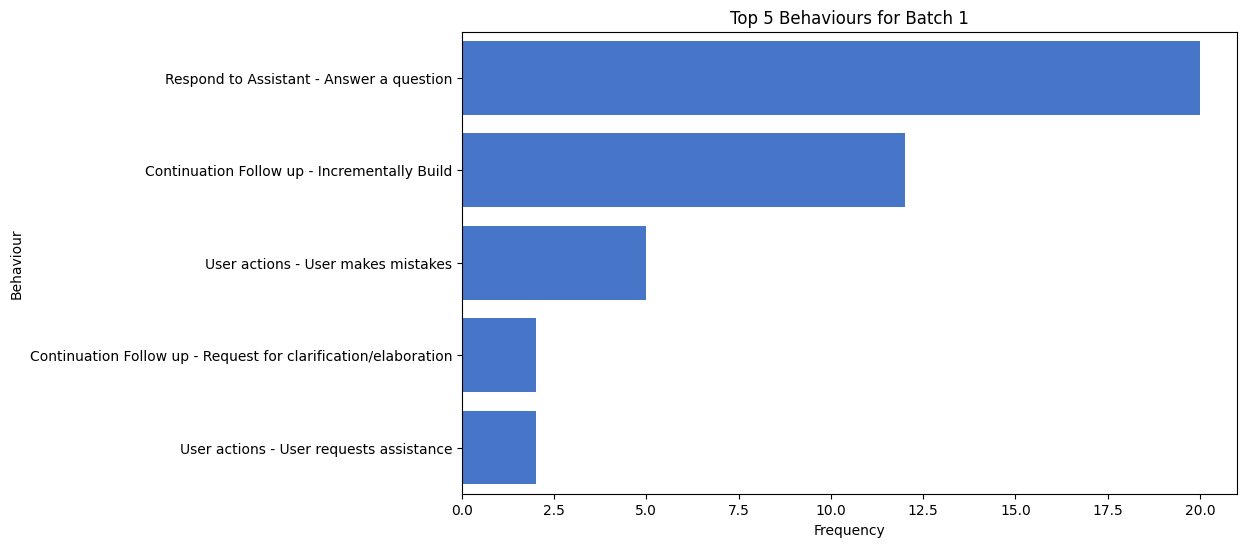

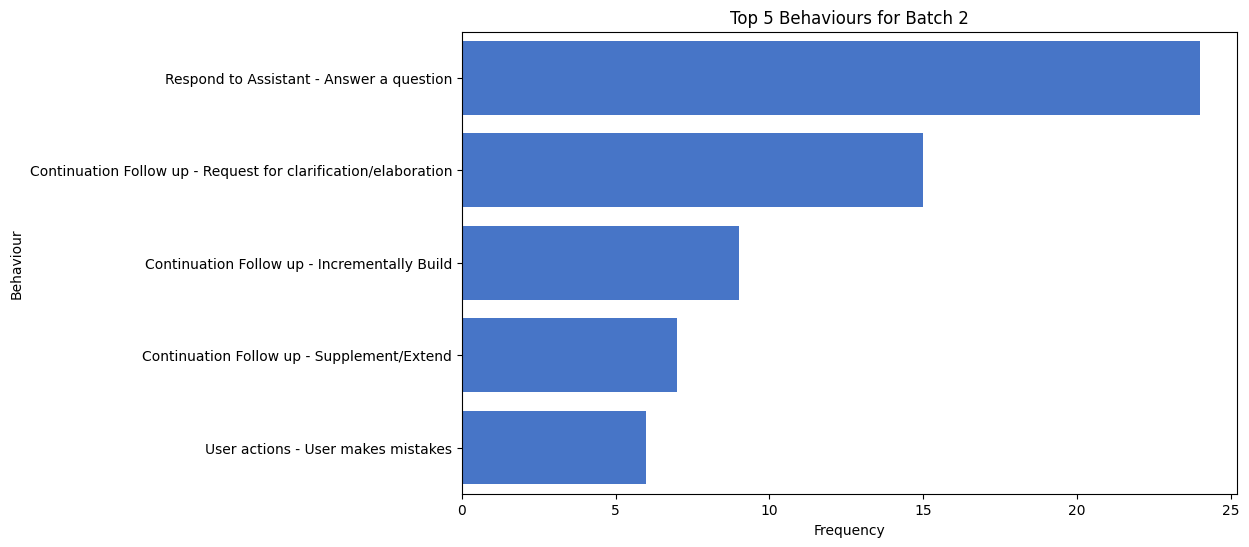

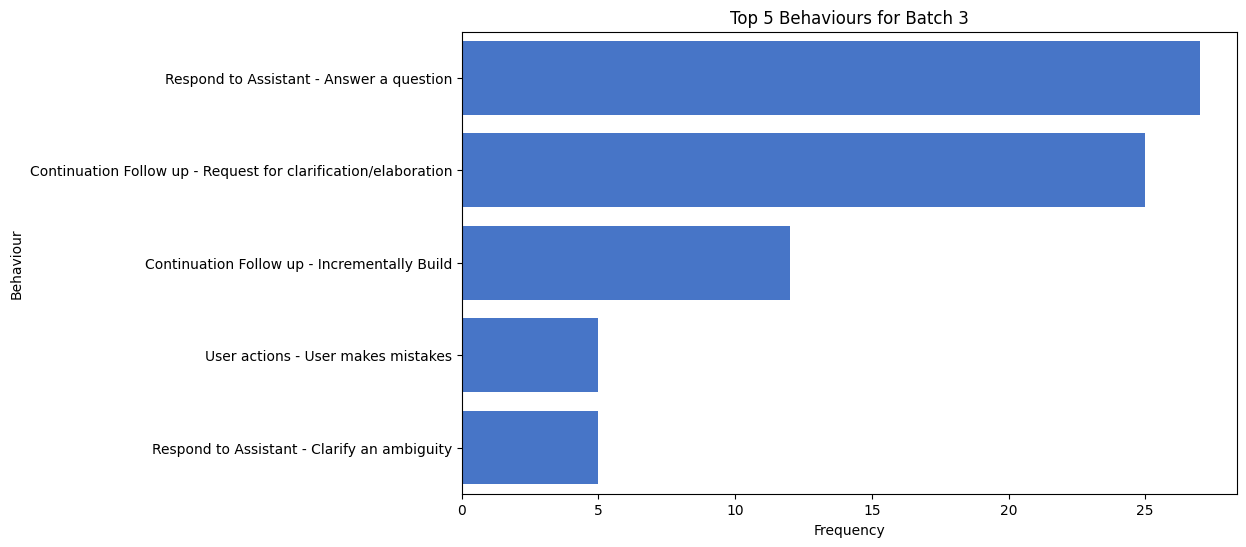

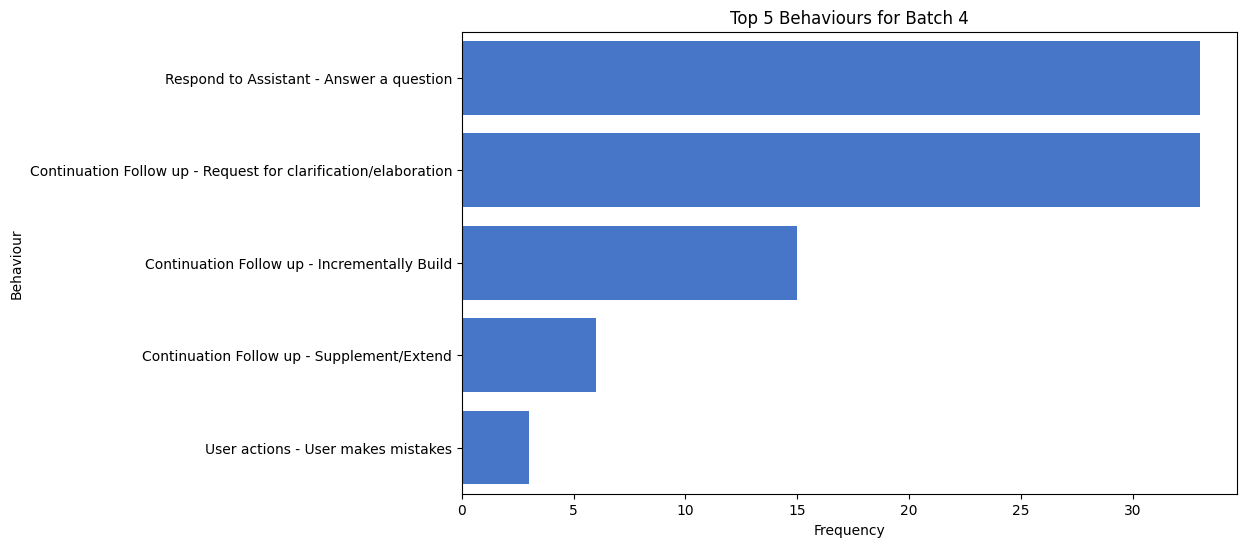

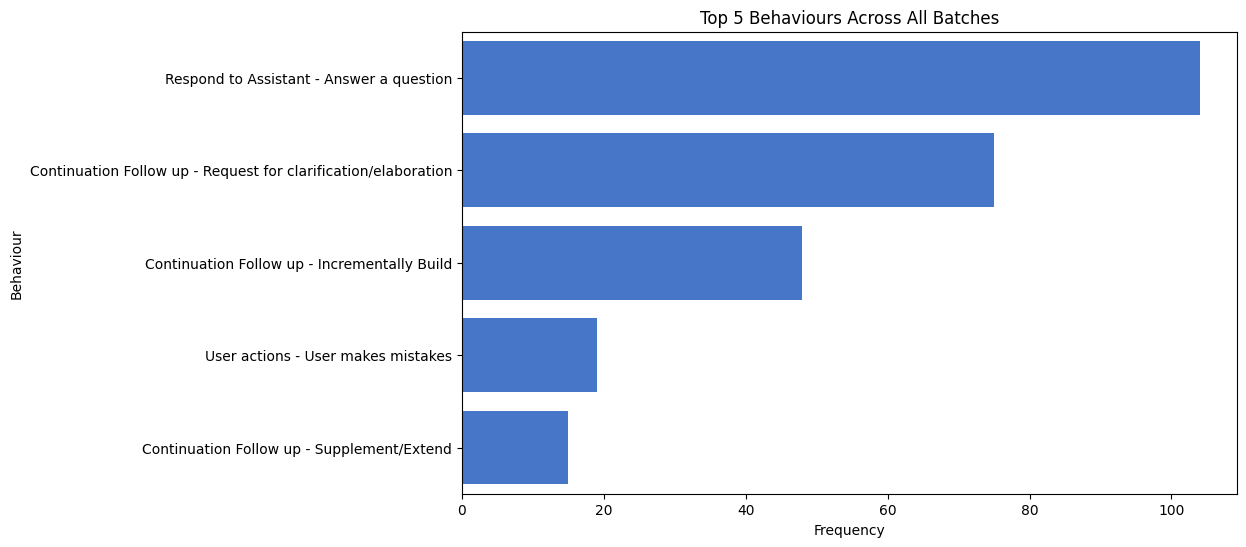

In [40]:
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

turing_palette = [
    "#326FDC",  # Celtic Blue
    "#47ABFD",  # Argentinian Blue
    "#959595",  # Battleship gray
    "#FFFFFF",  # White
    "#EFEFEF",  # Anti-flash white
    "#000000",  # Black
]

def compute_frequencies(batches):
    frequency_list = []
    for batch in batches:
        counter = Counter()
        for item in batch:
            for behaviour in item['behaviours']:
                top_sub_pair = (behaviour['top_level'], behaviour['sub_level'])
                counter[top_sub_pair] += 1
        frequency_list.append(counter)
    return frequency_list


frequencies = compute_frequencies(batches)
frequencies


def plot_top_behaviours(frequencies, title, top_n=5):
    # Combine all counters and get the most common behaviours
    combined_counter = Counter()
    for freq in frequencies:
        combined_counter.update(freq)
    top_behaviours = combined_counter.most_common(top_n)

    # Prepare data for seaborn barplot
    behaviours, counts = zip(*top_behaviours)
    sns.set_palette(sns.color_palette(turing_palette))
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=[f'{behaviour[0]} - {behaviour[1]}' for behaviour in behaviours])
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Behaviour')
    plt.show()

for i, batch in enumerate(frequencies, start=1):
    plot_top_behaviours([batch], f'Top 5 Behaviours for Batch {i}')

plot_top_behaviours(frequencies, 'Top 5 Behaviours Across All Batches')



In [30]:
frequencies

[Counter({('Respond to Assistant', 'Answer a question'): 5,
          ('Continuation Follow up', 'Incrementally Build'): 3,
          ('Continuation Follow up', 'Supplement/Extend'): 1,
          ('User actions', 'User requests assistance'): 1,
          ('User actions', 'User makes mistakes'): 1}),
 Counter({('Respond to Assistant', 'Answer a question'): 7,
          ('Continuation Follow up',
           'Request for clarification/elaboration'): 4,
          ('Respond to Assistant', 'Clarify an ambiguity'): 3,
          ('Continuation Follow up', 'Incrementally Build'): 2,
          ('User actions', 'User confronts assistant about mistakes'): 1,
          ('Continuation Follow up', 'Request alternatives'): 1,
          ('User actions', 'User makes mistakes'): 1,
          ('User actions', 'User requests assistance'): 1})]

In [20]:
delivered_df[conversations[0]['colab_link'] == delivered_df['task_link']].iloc[0]['batch_id']

1

In [6]:
from src.llm_reviewer.llm_api import make_llm_request, LLMAPIFactory


CLASSIFY_PROMPT = """
Your task is to classify a sample of text data given provided context for classification. Output in JSON.

**Classification is allowed to include multiple classes at once, aka tagging**: {multiclass}

# CONTEXT START
{context_prompt}
# CONTEXT END

# AVAILABLE CLASSES START
{classes}
If you are uncertain or no classes fit the sample, leave classes field an empty array [].
# AVAILABLE CLASSES END

# JSON OUTPUT FORMAT START
{{"classes": ["class_name"]}}
# JSON OUTPUT FORMAT END
"""

CLASSIFY_INPUT_PROMPT = """
# SAMPLE TO CLASSIFY START
{sample}
# SAMPLE TO CLASSIFY END

Your answer ->
"""

def classify(sample, context_prompt, classes=None, multiclass=False):
    if classes is None:
        classes = 'Classes are not provided, please use an appropriate class name, max length is 5 words.'
    INPUT_PROMPT = """
    # SAMPLE START
    {sample}
    # SAMPLE END""".strip()
    llm_client = LLMAPIFactory().get()
    classes = make_llm_request(
        llm_client,
        [{'role': 'system', 'content': CLASSIFY_PROMPT.format(context_prompt=context_prompt, classes=classes, multiclass=multiclass)},
         {'role': 'user', 'content': CLASSIFY_INPUT_PROMPT.format(sample=sample)}],
        'gpt-4-1106-preview',
        temperature= 0.0,
        max_tokens = 4000,
        response_format = {'type': "json_object"},
        retries = 3,
        seed=42
    )
    return classes['classes'] if 'classes' in classes else None